In [1]:
from sklearn.datasets import fetch_mldata
import numpy as np
import matplotlib.pyplot as plt
import time as tm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# Fetch dataset
mnist = fetch_mldata('MNIST original')

# Split dataset into training set and test set
n_train = 60000
n_test = 10000

train_idx = np.arange(0,n_train)
test_idx = np.arange(n_train+1,n_train+n_test)

X_train, y_train = mnist.data[train_idx], mnist.target[train_idx]
X_test, y_test = mnist.data[test_idx], mnist.target[test_idx]

## Image deskewing

Deskewing is the process of straightening an image that has been scanned or written crookedly

In [2]:
from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

In [3]:
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())

In [4]:
def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

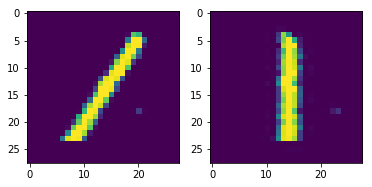

In [5]:
example_idx = 10000

plt.subplot(1, 2, 1)
plt.imshow(X_train[example_idx].reshape(28,28))

newim = deskew(X_train[example_idx].reshape(28,28))
plt.subplot(1, 2, 2)
plt.imshow(newim)
plt.show()

In [6]:
X_train_deskewed = deskewAll(X_train)
X_test_deskewed = deskewAll(X_test)

## K-Nearest-Neighbours

In [8]:
from sklearn.neighbors import KNeighborsClassifier

### Experiments

In [36]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_train_deskewed, y_train, test_size=0.33)

start = tm.time()
k = 9

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_exp, y_train_exp)

score = accuracy_score(y_test_exp, knn.predict(X_test_exp))
minutes = (tm.time() - start) / 60
print("%d Nearest Neighbours. Score: %f Time elapsed: %d minutes" % (k, score, minutes))

9 Nearest Neighbours. Score: 0.981919 Time elapsed: 21 minutes


### Parameter Tuning

K-Fold Cross Validation for 3 neighbours took 41 minutes
K-Fold Cross Validation for 5 neighbours took 33 minutes
K-Fold Cross Validation for 7 neighbours took 34 minutes
K-Fold Cross Validation for 9 neighbours took 34 minutes
K-Fold Cross Validation for 11 neighbours took 34 minutes
K-Fold Cross Validation for 13 neighbours took 34 minutes
K-Fold Cross Validation for 15 neighbours took 34 minutes
K-Fold Cross Validation for 17 neighbours took 33 minutes
K-Fold Cross Validation for 19 neighbours took 34 minutes
K-Fold Cross Validation for 21 neighbours took 34 minutes
K-Fold Cross Validation for 23 neighbours took 34 minutes
K-Fold Cross Validation for 25 neighbours took 34 minutes
K-Fold Cross Validation for 27 neighbours took 35 minutes
K-Fold Cross Validation for 29 neighbours took 34 minutes
Optimal k for k-nn is: 3
Cross validation took 29323 seconds


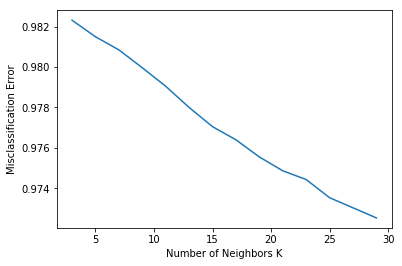

In [9]:
neighbours = [x for x in range(3,30,2)]
cv_scores = []

start = tm.time()
for k in neighbours:
    start_iter = tm.time()
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_deskewed, y_train, scoring='accuracy', n_jobs=3)
    cv_scores.append(scores.mean())
    iteration = (tm.time() - start_iter) / 60
    print("K-Fold Cross Validation for %d neighbours took %d minutes" % (k, iteration))

mse = [1 - x for x in cv_scores]
optimal_k = neighbours[mse.index(min(mse))] # optimal k according to cv is 3
print('Optimal k for k-nn is: %d\nCross validation took %d seconds' % (optimal_k, tm.time() - start))
    
plt.plot(neighbours, mse)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

## Linear Discriminant Analysis

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Experiments

In [13]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_train_deskewed, y_train, test_size=0.33)

start = tm.time()

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_exp, y_train_exp)

score = accuracy_score(y_test_exp, lda.predict(X_test_exp))
minutes = (tm.time() - start) / 60
print("Linear Discriminant Analysis. Score: %f Time elapsed: %d minutes" % (score, minutes))

/usr/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Linear Discriminant Analysis. Score: 0.910808 Time elapsed: 2 minutes


## Support Vector Machine

In [8]:
from sklearn.svm import SVC

### Experiments

In [20]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_train_deskewed, y_train, test_size=0.33)

start = tm.time()

C = 10
kernel = 'rbf'
gamma = 0.01

svc = SVC(C=C, kernel=kernel)
svc.fit(X_train_exp, y_train_exp)

score = accuracy_score(y_test_exp, svc.predict(X_test_exp))
minutes = (tm.time() - start) / 60
print("Support Vector Machine. Score: %f Time elapsed: %d minutes" % (score, minutes))

Support Vector Machine. Score: 0.972475 Time elapsed: 5 minutes


### Parameter Tuning

In [ ]:
C_range = np.logspace(-3, 2, 6)
gamma_range = np.logspace(-3, 2, 6)

parameters = [{'kernel': ['rbf'],
               'gamma': gamma_range,
                'C': C_range},
              {'kernel': ['linear'], 'C': C_range}]

svc = SVC()
start = tm.time()
clf = GridSearchCV(svc, parameters, scoring="accuracy", n_jobs=3)
clf.fit(X_train_deskewed, y_train)
elapsed = (tm.time() - start) / 60

print("Best score: %0.5f" % (clf.best_score_))
print("Best parameters: %s" % (str(clf.best_params_)))
print("Time elapsed: %d minutes" % (elapsed))

means = clf.cv_results_['mean_test_score']
for mean, params in zip(means, clf.cv_results_['params']):
    print("%0.5f accuracy for parameters: %r"
          % (mean, params))


## Sources

* lecture slides
* http://scikit-learn.org
* https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
* http://pyml.sourceforge.net/doc/howto.pdf
* https://fsix.github.io/mnist/Deskewing.html